In [289]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

from plotly import plotly
import plotly.offline as offline
import plotly.graph_objs as go
offline.init_notebook_mode()
from collections import Counter

AttributeError: module 'boto' has no attribute 'plugin'

# 1.1 Reading given data

In [113]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [114]:
print("Number of data points in train data", project_data.shape)
print('-'*60)
print("The attribute data:", project_data.columns.values )

Number of data points in train data (109248, 17)
------------------------------------------------------------
The attribute data: ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [115]:
print("No of data points in train data", resource_data.shape)
print( resource_data.columns.values)
resource_data.head(2)

No of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [116]:
Project_A_R = project_data['project_is_approved'].value_counts()

In [117]:
print("No of projects approved",Project_A_R[1],"(",(Project_A_R[1]/(Project_A_R[1] + Project_A_R[0]))*100,"percent)")
print("No of projects not approved",Project_A_R[0],"(",(Project_A_R[0]/(Project_A_R[1] + Project_A_R[0]))*100,"percent)")

No of projects approved 92706 ( 84.85830404217927 percent)
No of projects not approved 16542 ( 15.141695957820739 percent)


# Univariate Analysis: School State

In [118]:
# Pandas dataframe groupby count, mean: https://stackoverflow.com/a/19385591/4084039

temp = pd.DataFrame(project_data.groupby("school_state")["project_is_approved"].mean()).reset_index()
# if you have data which contain only 0 and 1, then the mean = percentage (think about it)
temp.columns = ['state_code', 'num_proposals']

In [119]:
# https://www.csi.cuny.edu/sites/default/files/pdf/administration/ops/2letterstabbrev.pdf
temp.sort_values(by=['num_proposals'], inplace=True)
print("States with lowest % approvals")
print(temp.head(5))
print('='*50)
print("States with highest % approvals")
print(temp.tail(5))

States with lowest % approvals
   state_code  num_proposals
46         VT       0.800000
7          DC       0.802326
43         TX       0.813142
26         MT       0.816327
18         LA       0.831245
States with highest % approvals
   state_code  num_proposals
30         NH       0.873563
35         OH       0.875152
47         WA       0.876178
28         ND       0.888112
8          DE       0.897959


##### Summary
- minimum project approvals for any state is 80%, maximum is 89.79%

In [120]:
#stacked bar plots matplotlib: https://matplotlib.org/gallery/lines_bars_and_markers/bar_stacked.html
def stack_plot(data, xtick, col2='project_is_approved', col3='total'):
    ind = np.arange(data.shape[0])
    plt.figure(figsize=(20,5))
    p1 = plt.bar(ind, data[col3].values)
    p2 = plt.bar(ind, data[col2].values)
    plt.ylabel('Projects')
    plt.title('Number of projects aproved vs rejected')
    plt.xticks(ind, list(data[xtick].values))
    plt.legend((p1[0], p2[0]), ('total', 'accepted'))
    plt.show()

In [121]:
def univariate_barplots(data, col1, col2='project_is_approved', top=False):
    # Count number of zeros in dataframe python: https://stackoverflow.com/a/51540521/4084039
    import pdb
    #pdb.set_trace()
    temp = pd.DataFrame(project_data.groupby(col1)[col2].agg(lambda x: x.eq(1).sum())).reset_index()

    # Pandas dataframe grouby count: https://stackoverflow.com/a/19385591/4084039
    temp['total'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'total':'count'})).reset_index()['total']
    #pdb.set_trace()
    temp['Avg'] = pd.DataFrame(project_data.groupby(col1)[col2].agg({'Avg':'mean'})).reset_index()['Avg']
    #pdb.set_trace()
    temp.sort_values(by=['total'],inplace=True, ascending=False)
    #pdb.set_trace()
    if top:
        #pdb.set_trace()
        temp = temp[0:top]
        #pdb.set_trace()
    stack_plot(temp, xtick=col1, col2=col2, col3='total')
    #pdb.set_trace()
    print(temp.head(5))
    #pdb.set_trace()
    print("="*50)
    print(temp.tail(5))

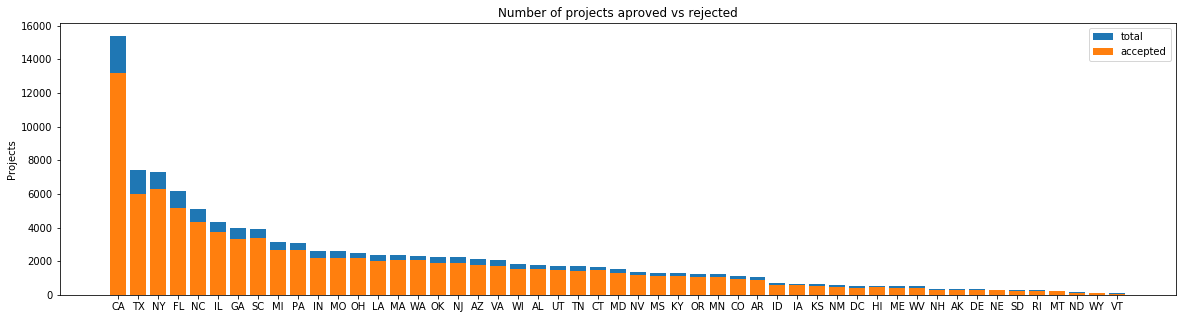

   school_state  project_is_approved  total       Avg
4            CA                13205  15388  0.858136
43           TX                 6014   7396  0.813142
34           NY                 6291   7318  0.859661
9            FL                 5144   6185  0.831690
27           NC                 4353   5091  0.855038
   school_state  project_is_approved  total       Avg
39           RI                  243    285  0.852632
26           MT                  200    245  0.816327
28           ND                  127    143  0.888112
50           WY                   82     98  0.836735
46           VT                   64     80  0.800000


In [122]:
univariate_barplots(project_data, 'school_state', 'project_is_approved', False)

##### Summary
- Huge difference in no of projects proposed by the states
- Though no of projects proposed by states are different, no of approval vs total is min of 80%
- Project approvals are independent on no of projects proposed

## 1.2.2 Univariate Analysis: teacher_prefix

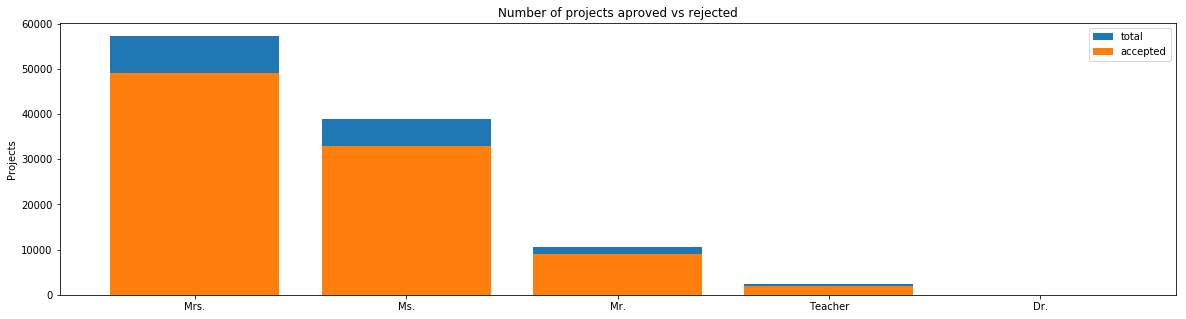

  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308
  teacher_prefix  project_is_approved  total       Avg
2           Mrs.                48997  57269  0.855559
3            Ms.                32860  38955  0.843537
1            Mr.                 8960  10648  0.841473
4        Teacher                 1877   2360  0.795339
0            Dr.                    9     13  0.692308


In [123]:
univariate_barplots(project_data, 'teacher_prefix', 'project_is_approved' , top=False)

##### Summary
- Huge difference in no of projects proposed by Mrs. vs Dr.
- Mrs. proposed more no of projects compared to other members
- Project approvals are more for Mrs.

### 1.2.3 Univariate Analysis: project_grade_category

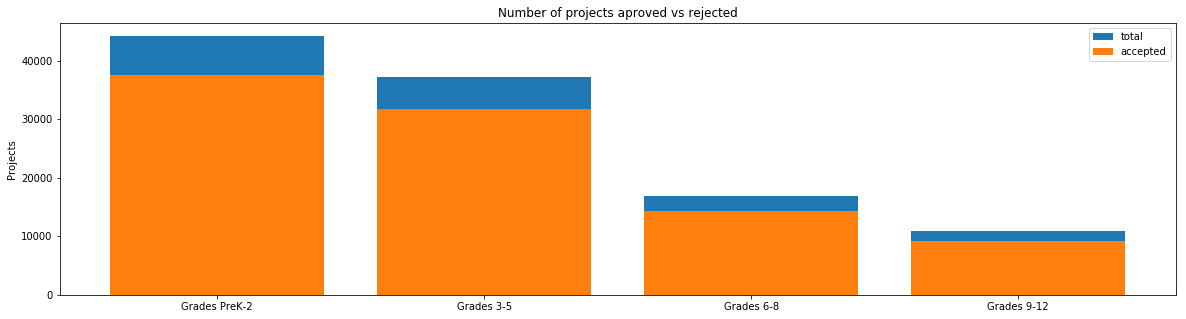

  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636
  project_grade_category  project_is_approved  total       Avg
3          Grades PreK-2                37536  44225  0.848751
0             Grades 3-5                31729  37137  0.854377
1             Grades 6-8                14258  16923  0.842522
2            Grades 9-12                 9183  10963  0.837636


In [124]:
univariate_barplots(project_data, 'project_grade_category', 'project_is_approved', top=False)

##### Summary
- No of proposal projects by Grades PreK-2 and Grades 3-5 are more compared to others
- Project approval rates are more for Grades 3-5 

### 1.2.4 Univariate Analysis: project_subject_categories

In [125]:
catogories = list(project_data['project_subject_categories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python
cat_list = []
for i in catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp+=j.strip()+" " #" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_') # we are replacing the & value into 
    cat_list.append(temp.strip())

In [126]:
project_data['clean_categories'] = cat_list
project_data.drop(['project_subject_categories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,"ESL, Literacy",Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,"Civics & Government, Team Sports",Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports


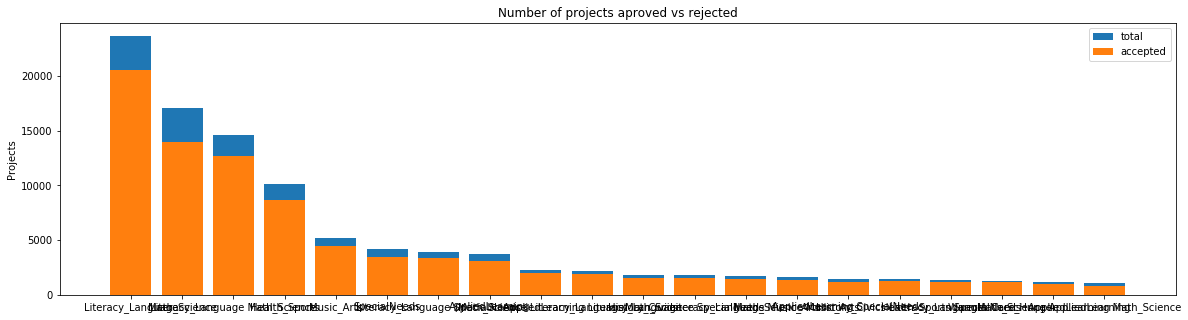

                  clean_categories  project_is_approved  total       Avg
24               Literacy_Language                20520  23655  0.867470
32                    Math_Science                13991  17072  0.819529
28  Literacy_Language Math_Science                12725  14636  0.869432
8                    Health_Sports                 8640  10177  0.848973
40                      Music_Arts                 4429   5180  0.855019
                    clean_categories  project_is_approved  total       Avg
19  History_Civics Literacy_Language                 1271   1421  0.894441
14        Health_Sports SpecialNeeds                 1215   1391  0.873472
50                Warmth Care_Hunger                 1212   1309  0.925898
33      Math_Science AppliedLearning                 1019   1220  0.835246
4       AppliedLearning Math_Science                  855   1052  0.812738


In [127]:
univariate_barplots(project_data, 'clean_categories', 'project_is_approved', top=20)

##### Summary

- % of projects approved in Warmth Care_Hunger category is more and applied learning math_science is less

In [128]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_categories'].values:
    my_counter.update(word.split())

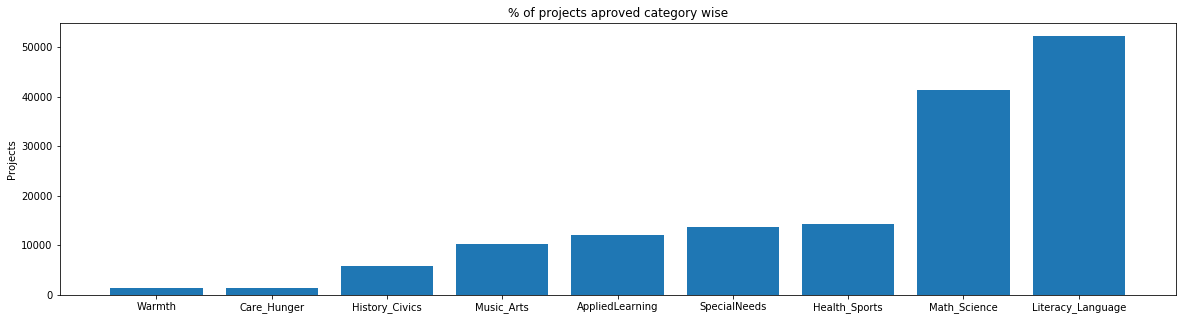

In [129]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
cat_dict = dict(my_counter)
sorted_cat_dict = dict(sorted(cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved category wise')
plt.xticks(ind, list(sorted_cat_dict.keys()))
plt.show()

In [130]:
for i, j in sorted_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Warmth               :      1388
Care_Hunger          :      1388
History_Civics       :      5914
Music_Arts           :     10293
AppliedLearning      :     12135
SpecialNeeds         :     13642
Health_Sports        :     14223
Math_Science         :     41421
Literacy_Language    :     52239


##### Summary
- No of proposal projects in  Literacy_Language category is more and Warmth category is less

### 1.2.4 Univariate Analysis: project_subject_categories

In [131]:
sub_catogories = list(project_data['project_subject_subcategories'].values)
# remove special characters from list of strings python: https://stackoverflow.com/a/47301924/4084039

# https://www.geeksforgeeks.org/removing-stop-words-nltk-python/
# https://stackoverflow.com/questions/23669024/how-to-strip-a-specific-word-from-a-string
# https://stackoverflow.com/questions/8270092/remove-all-whitespace-in-a-string-in-python

sub_cat_list = []
for i in sub_catogories:
    temp = ""
    # consider we have text like this "Math & Science, Warmth, Care & Hunger"
    for j in i.split(','): # it will split it in three parts ["Math & Science", "Warmth", "Care & Hunger"]
        if 'The' in j.split(): # this will split each of the catogory based on space "Math & Science"=> "Math","&", "Science"
            j=j.replace('The','') # if we have the words "The" we are going to replace it with ''(i.e removing 'The')
        j = j.replace(' ','') # we are placeing all the ' '(space) with ''(empty) ex:"Math & Science"=>"Math&Science"
        temp +=j.strip()+" "#" abc ".strip() will return "abc", remove the trailing spaces
        temp = temp.replace('&','_')
    sub_cat_list.append(temp.strip())

In [132]:
project_data['clean_subcategories'] = sub_cat_list
project_data.drop(['project_subject_subcategories'], axis=1, inplace=True)
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports


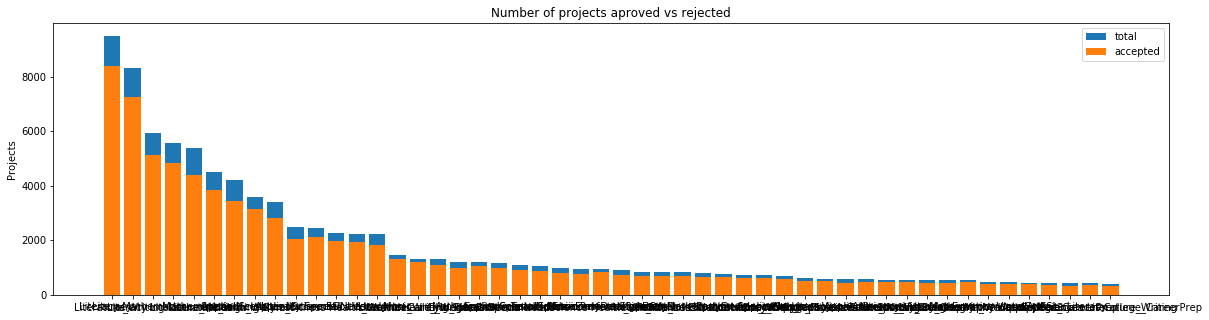

                clean_subcategories  project_is_approved  total       Avg
317                        Literacy                 8371   9486  0.882458
319            Literacy Mathematics                 7260   8325  0.872072
331  Literature_Writing Mathematics                 5140   5923  0.867803
318     Literacy Literature_Writing                 4823   5571  0.865733
342                     Mathematics                 4385   5379  0.815207
                    clean_subcategories  project_is_approved  total       Avg
196       EnvironmentalScience Literacy                  389    444  0.876126
127                                 ESL                  349    421  0.828979
79                   College_CareerPrep                  343    421  0.814727
17   AppliedSciences Literature_Writing                  361    420  0.859524
3    AppliedSciences College_CareerPrep                  330    405  0.814815


In [133]:
univariate_barplots(project_data, 'clean_subcategories', 'project_is_approved', top=50)


##### Summary

- % of projects approved in subcategories Literacy Mathematics is more and College_CareerPrep is less

In [134]:
# count of all the words in corpus python: https://stackoverflow.com/a/22898595/4084039
from collections import Counter
my_counter = Counter()
for word in project_data['clean_subcategories'].values:
    my_counter.update(word.split())

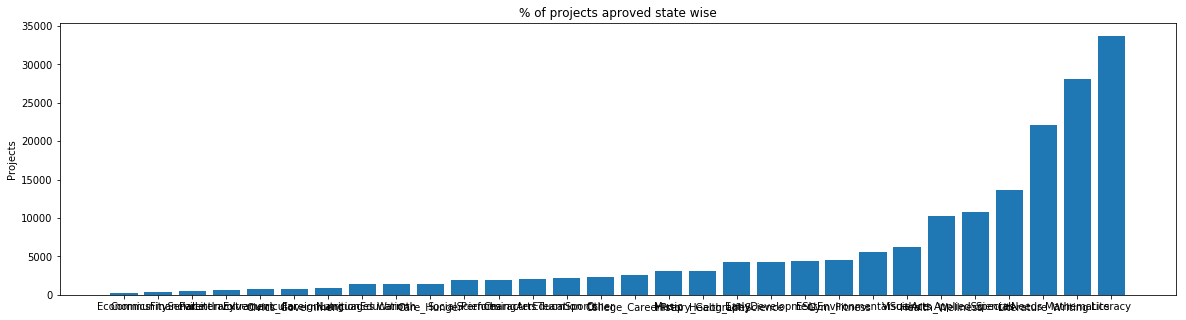

In [135]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
sub_cat_dict = dict(my_counter)
sorted_sub_cat_dict = dict(sorted(sub_cat_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_sub_cat_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_sub_cat_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_sub_cat_dict.keys()))
plt.show()

In [136]:
for i, j in sorted_sub_cat_dict.items():
    print("{:20} :{:10}".format(i,j))

Economics            :       269
CommunityService     :       441
FinancialLiteracy    :       568
ParentInvolvement    :       677
Extracurricular      :       810
Civics_Government    :       815
ForeignLanguages     :       890
NutritionEducation   :      1355
Warmth               :      1388
Care_Hunger          :      1388
SocialSciences       :      1920
PerformingArts       :      1961
CharacterEducation   :      2065
TeamSports           :      2192
Other                :      2372
College_CareerPrep   :      2568
Music                :      3145
History_Geography    :      3171
Health_LifeScience   :      4235
EarlyDevelopment     :      4254
ESL                  :      4367
Gym_Fitness          :      4509
EnvironmentalScience :      5591
VisualArts           :      6278
Health_Wellness      :     10234
AppliedSciences      :     10816
SpecialNeeds         :     13642
Literature_Writing   :     22179
Mathematics          :     28074
Literacy             :     33700


##### Summary
- No of proposal projects subcategory  Literacy subcategory is more and Economics subcategory is less

## 1.2.6 Univariate Analysis: Text features (Title)

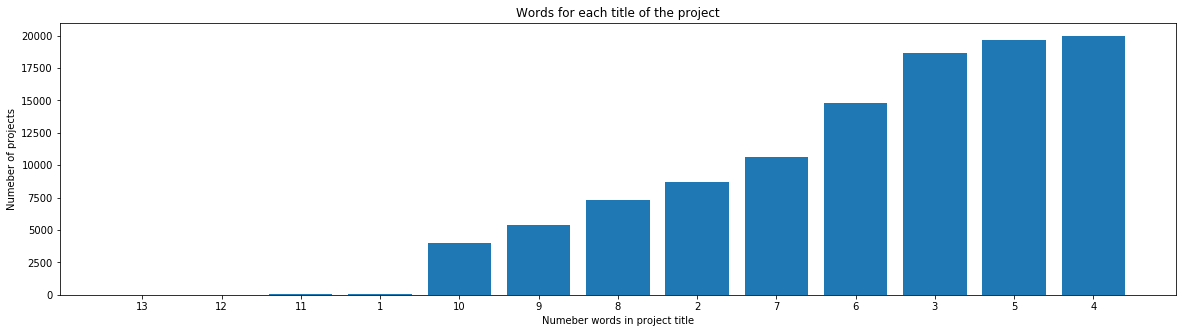

In [137]:
#How to calculate number of words in a string in DataFrame: https://stackoverflow.com/a/37483537/4084039
word_count = project_data['project_title'].str.split().apply(len).value_counts()
word_dict = dict(word_count)
word_dict = dict(sorted(word_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(word_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(word_dict.values()))

plt.ylabel('Numeber of projects')
plt.xlabel('Numeber words in project title')
plt.title('Words for each title of the project')
plt.xticks(ind, list(word_dict.keys()))
plt.show()

In [138]:
approved_title_word_count = project_data[project_data['project_is_approved']==1]['project_title'].str.split().apply(len)
approved_title_word_count = approved_title_word_count.values

rejected_title_word_count = project_data[project_data['project_is_approved']==0]['project_title'].str.split().apply(len)
rejected_title_word_count = rejected_title_word_count.values

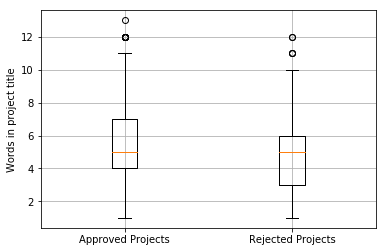

In [139]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_title_word_count, rejected_title_word_count])
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project title')
plt.grid()
plt.show()

##### Summary
- For Approved projects mean of no of words in project title is more compared to rejected projects

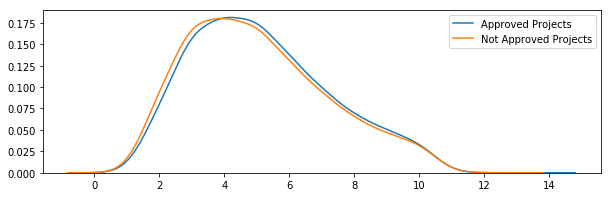

In [140]:
plt.figure(figsize=(10,3))
sns.kdeplot(approved_title_word_count,label="Approved Projects", bw=0.6)
sns.kdeplot(rejected_title_word_count,label="Not Approved Projects", bw=0.6)
plt.legend()
plt.show()

##### Summary
- For Approved projects PDF of curve is slightly leading with more of no of words compared to rejected projects

### 1.2.7 Univariate Analysis: Text features (Project Essay's)

In [141]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [142]:
approved_word_count = project_data[project_data['project_is_approved']==1]['essay'].str.split().apply(len)
approved_word_count = approved_word_count.values

rejected_word_count = project_data[project_data['project_is_approved']==0]['essay'].str.split().apply(len)
rejected_word_count = rejected_word_count.values

In [143]:
project_data.head(2)

,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay
0,160221,p253737,c90749f5d961ff158d4b4d1e7dc665fc,Mrs.,IN,2016-12-05 13:43:57,Grades PreK-2,Educational Support for English Learners at Home,My students are English learners that are work...,"\""The limits of your language are the limits o...",NaN,NaN,My students need opportunities to practice beg...,0,0,Literacy_Language,ESL Literacy,My students are English learners that are work...
1,140945,p258326,897464ce9ddc600bced1151f324dd63a,Mr.,FL,2016-10-25 09:22:10,Grades 6-8,Wanted: Projector for Hungry Learners,Our students arrive to our school eager to lea...,The projector we need for our school is very c...,NaN,NaN,My students need a projector to help with view...,7,1,History_Civics Health_Sports,Civics_Government TeamSports,Our students arrive to our school eager to lea...


##### Summary
- Merging essays and printing the dataframe

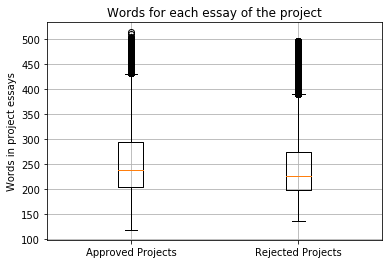

In [144]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_word_count, rejected_word_count])
plt.title('Words for each essay of the project')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Words in project essays')
plt.grid()
plt.show()

##### Summary
- For Approved projects mean of no of words in essay is more compared to rejected projects

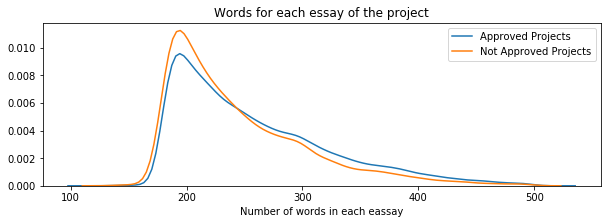

In [235]:
plt.figure(figsize=(10,3))
sns.distplot(approved_word_count, hist=False, label="Approved Projects")
sns.distplot(rejected_word_count, hist=False, label="Not Approved Projects")
plt.title('Words for each essay of the project')
plt.xlabel('Number of words in each eassay')
plt.legend()
plt.show()

##### Summary
- For Approved projects PDF of curve(Essay) is slightly leading with more of no of words compared to rejected projects

### 1.2.8 Univariate Analysis: Cost per project

In [146]:
# we get the cost of the project using resource.csv file
resource_data.head(2)

,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


In [147]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [148]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')


In [149]:
project_data = project_data.sample(n=5000, replace=False, random_state=1)


(5000, 20)
        Unnamed: 0       id                        teacher_id teacher_prefix  \
66607       132247  p036816  a2ec77419c3b905cb0b993a863e260e3           Mrs.   
78558        58194  p005625  1d93830d48afc261e3a41e00c30c9324           Mrs.   
80326       166367  p224481  60cd443dfd54b245329e77f2912eae01           Mrs.   
78185        64458  p080823  3fbef3277fd114ced0b220c39bc5471b            Ms.   
1498         96817  p128639  b61f60977bb8af0655bcdf3afa85b32c           Mrs.   
54317        28083  p101430  55eefa8df0652403f258c201f96fffb3           Mrs.   
92822        31041  p194496  d767aacc407272707198d4c00a558714           Mrs.   
70899        98363  p200573  de9df25f0170bf9ccf38365800df7548            Ms.   
26091       118832  p031303  3dcd409071498734f797d8f4e20c581d            Ms.   
1293        141508  p057458  d799f6d12baac287d079a07c8d9d3e4b        Teacher   
97369        44923  p132394  0b13b59a05e3321539d68e8e21497457            Ms.   
53794         8621  p178360  

## Note: Taking 5k Sample data to avoid memory issues on PC

In [150]:
approved_price = project_data[project_data['project_is_approved']==1]['price'].values

rejected_price = project_data[project_data['project_is_approved']==0]['price'].values

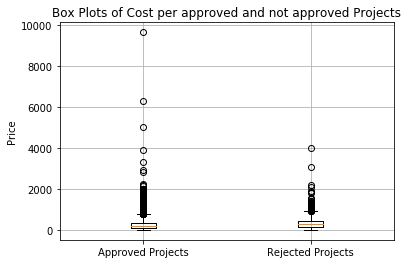

In [151]:
# https://glowingpython.blogspot.com/2012/09/boxplot-with-matplotlib.html
plt.boxplot([approved_price, rejected_price])
plt.title('Box Plots of Cost per approved and not approved Projects')
plt.xticks([1,2],('Approved Projects','Rejected Projects'))
plt.ylabel('Price')
plt.grid()
plt.show()

#### Summary
- 75% of approved projects cost is less than 500
- Slightly mean price of the approved projects is less compared to Rejected projects

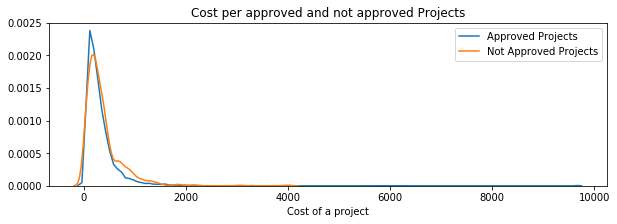

In [152]:
plt.figure(figsize=(10,3))
sns.distplot(approved_price, hist=False, label="Approved Projects")
sns.distplot(rejected_price, hist=False, label="Not Approved Projects")
plt.title('Cost per approved and not approved Projects')
plt.xlabel('Cost of a project')
plt.legend()
plt.show()

#### Summary
- Slightly price of the approved projects is lagging compared to Rejected projects

In [154]:
# http://zetcode.com/python/prettytable/
from prettytable import PrettyTable

#If you get a ModuleNotFoundError error , install prettytable using: pip3 install prettytable

x = PrettyTable()
x.field_names = ["Percentile", "Approved Projects", "Not Approved Projects"]

for i in range(0,101,5):
    x.add_row([i,np.round(np.percentile(approved_price,i), 3), np.round(np.percentile(rejected_price,i), 3)])
print(x)

+------------+-------------------+-----------------------+
| Percentile | Approved Projects | Not Approved Projects |
+------------+-------------------+-----------------------+
|     0      |        0.9        |          4.96         |
|     5      |       13.53       |         36.031        |
|     10     |       30.656      |         76.232        |
|     15     |       55.994      |        101.246        |
|     20     |       74.026      |         124.28        |
|     25     |       96.72       |         148.58        |
|     30     |       115.0       |        169.958        |
|     35     |      136.008      |        200.292        |
|     40     |       156.97      |        215.554        |
|     45     |       179.0       |        239.952        |
|     50     |       199.98      |         266.74        |
|     55     |      224.982      |        294.445        |
|     60     |      258.036      |         332.32        |
|     65     |       284.91      |         370.23       

### 1.2.9 Univariate Analysis: teacher_number_of_previously_posted_projects

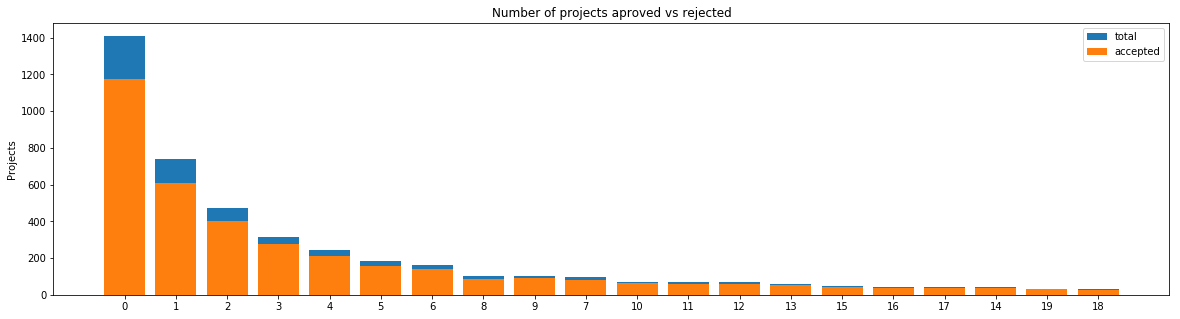

   teacher_number_of_previously_posted_projects  project_is_approved  total  \
0                                             0                 1177   1409   
1                                             1                  606    741   
2                                             2                  399    470   
3                                             3                  279    317   
4                                             4                  212    244   

        Avg  
0  0.835344  
1  0.817814  
2  0.848936  
3  0.880126  
4  0.868852  
    teacher_number_of_previously_posted_projects  project_is_approved  total  \
16                                            16                   38     43   
17                                            17                   35     41   
14                                            14                   35     40   
19                                            19                   31     32   
18                                       

In [155]:
univariate_barplots(project_data, 'teacher_number_of_previously_posted_projects', 'project_is_approved', top=20)

#### Summary
- No of teachers posted project in earlier times is 18

### 1.3 Text preprocessing

project_data.head(2)

In [276]:
# printing some random essays.
print(project_data['essay'].values[0])
print("="*50)
print(project_data['essay'].values[150])
print("="*50)
print(project_data['essay'].values[1000])
print("="*50)
print(project_data['essay'].values[2000])
print("="*50)
print(project_data['essay'].values[3999])
print("="*50)


My middle school students walk into our classroom every day full of energy, life, and excited for what is in store for them that day. My students are underprivileged and under served. We have 100% free and reduced lunch here at my school. \r\nWhile they show a passion for life, there are a lot of experiences\r\nthey haven't had the opportunity to enjoy. Our school, though lacking in resources, know how to make the most of what we have. We depend on kind donors for many of the \"extras\r\nMakerspaces are zones of self-directed learning. They give students a chance to have hands-on character, coupled with the tools and raw materials that support invention, provide the ultimate workshop for the young mind and the perfect educational space for individuals who learn best by doing.\r\nThe donations for this project will improve my classroom by reducing the amount of behavioral issues, because I will be able to provide the appropriate stimulation that my students need to be successful in clas

#### Summary
- Essays printing

In [158]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [160]:
sent = decontracted(project_data['essay'].values[4000])
print(sent)
print("="*50)

My classroom is made up of a diverse group of students who come from a variety of backgrounds. My students are inquisitive, motivated, and determined to learn. We have spent the beginning of this school year focusing on contributing to a team and learning how to work together, and it seems to be paying off. \r\nLike most 9 and 10 year olds today, my students love technology.  My students are most engaged when we are hard at work in the computer lab, or when we break out chromebooks in the classroom to do some research.Currently my students have access to five Chromebooks to use in our classroom. Five additional  Chromebooks will allow more of my students access to technology on a regular basis. \r\nIn the past I have had to beg and borrow other teachers to use their laptops in order provide my students with the resources they need.  My students need the computers to complete research projects, to read books online, and to practice typing the final drafts of their written masterpieces. 

In [161]:
# \r \n \t remove from string python: http://texthandler.com/info/remove-line-breaks-python/
sent = sent.replace('\\r', ' ')
sent = sent.replace('\\"', ' ')
sent = sent.replace('\\n', ' ')
print(sent)

My classroom is made up of a diverse group of students who come from a variety of backgrounds. My students are inquisitive, motivated, and determined to learn. We have spent the beginning of this school year focusing on contributing to a team and learning how to work together, and it seems to be paying off.   Like most 9 and 10 year olds today, my students love technology.  My students are most engaged when we are hard at work in the computer lab, or when we break out chromebooks in the classroom to do some research.Currently my students have access to five Chromebooks to use in our classroom. Five additional  Chromebooks will allow more of my students access to technology on a regular basis.   In the past I have had to beg and borrow other teachers to use their laptops in order provide my students with the resources they need.  My students need the computers to complete research projects, to read books online, and to practice typing the final drafts of their written masterpieces.  I h

In [162]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
print(sent)

My classroom is made up of a diverse group of students who come from a variety of backgrounds My students are inquisitive motivated and determined to learn We have spent the beginning of this school year focusing on contributing to a team and learning how to work together and it seems to be paying off Like most 9 and 10 year olds today my students love technology My students are most engaged when we are hard at work in the computer lab or when we break out chromebooks in the classroom to do some research Currently my students have access to five Chromebooks to use in our classroom Five additional Chromebooks will allow more of my students access to technology on a regular basis In the past I have had to beg and borrow other teachers to use their laptops in order provide my students with the resources they need My students need the computers to complete research projects to read books online and to practice typing the final drafts of their written masterpieces I have 25 students in each

In [163]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [164]:
# Combining all the above statemennts 
from tqdm import tqdm
preprocessed_essays = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['essay'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_essays.append(sent.lower().strip())

100%|██████████| 5000/5000 [00:03<00:00, 1478.50it/s]


#### Summary
- Text preprocessing, Removing stop words, special characters, slashes

In [237]:
# after preprocesing
preprocessed_essays[2000]

'the students school curious like sponges want soak taught the school constant safe place they come vast backgrounds school one community the children not enormous amount things bring classroom heart the community low socioeconomic neighborhood students live shelters single parent homes foster homes we children pre k 5th grade transient population children become homeless move drop hat while room i needed make fun place learn the children 2 student groups deserve need ipads they volunteer part the green team the peer mediation team want best job these ipads let children document success collect data take photos create presentations right using paper pencils jobs 2017 unacceptable i need 4 2 available peer mediators 2 the green team these children not technology homes must learn possibilities succeed junior high future lives nannan'

#### Summary
- after preprocessing printing the essays

### 1.3.2 Project title Text


In [167]:
preprocessed_title = []
# tqdm is for printing the status bar
for sentance in tqdm(project_data['project_title'].values):
    sent = decontracted(sentance)
    sent = sent.replace('\\r', ' ')
    sent = sent.replace('\\"', ' ')
    sent = sent.replace('\\n', ' ')
    sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
    # https://gist.github.com/sebleier/554280
    sent = ' '.join(e for e in sent.split() if e not in stopwords)
    preprocessed_title.append(sent.lower().strip())

100%|██████████| 5000/5000 [00:00<00:00, 34238.38it/s]


In [168]:
preprocessed_title[1000]

'digital storytelling ipads'

#### Summary
- after preprocessing printing the project title

### 1. 4 Preparing data for models

In [169]:
project_data.columns

Index(['Unnamed: 0', 'id', 'teacher_id', 'teacher_prefix', 'school_state',
       'project_submitted_datetime', 'project_grade_category', 'project_title',
       'project_essay_1', 'project_essay_2', 'project_essay_3',
       'project_essay_4', 'project_resource_summary',
       'teacher_number_of_previously_posted_projects', 'project_is_approved',
       'clean_categories', 'clean_subcategories', 'essay', 'price',
       'quantity'],
      dtype='object')

we are going to consider

       - school_state : categorical data
       - clean_categories : categorical data
       - clean_subcategories : categorical data
       - project_grade_category : categorical data
       - teacher_prefix : categorical data
       
       - project_title : text data
       - text : text data
       - project_resource_summary: text data
       
       - quantity : numerical
       - teacher_number_of_previously_posted_projects : numerical
       - price : numerical

### 1.4.1 Vectorizing Categorical data

- https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/handling-categorical-and-numerical-features/

In [170]:
# we use count vectorizer to convert the values into one hot encoded features
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(vocabulary=list(sorted_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_categories'].values)
print(vectorizer.get_feature_names())


categories_one_hot = vectorizer.transform(project_data['clean_categories'].values)
print("Shape of matrix after one hot encodig ",categories_one_hot.shape)

['Warmth', 'Care_Hunger', 'History_Civics', 'Music_Arts', 'AppliedLearning', 'SpecialNeeds', 'Health_Sports', 'Math_Science', 'Literacy_Language']
Shape of matrix after one hot encodig  (5000, 9)


In [171]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_sub_cat_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['clean_subcategories'].values)
print(vectorizer.get_feature_names())


sub_categories_one_hot = vectorizer.transform(project_data['clean_subcategories'].values)
print("Shape of matrix after one hot encodig ",sub_categories_one_hot.shape)

['Economics', 'CommunityService', 'FinancialLiteracy', 'ParentInvolvement', 'Extracurricular', 'Civics_Government', 'ForeignLanguages', 'NutritionEducation', 'Warmth', 'Care_Hunger', 'SocialSciences', 'PerformingArts', 'CharacterEducation', 'TeamSports', 'Other', 'College_CareerPrep', 'Music', 'History_Geography', 'Health_LifeScience', 'EarlyDevelopment', 'ESL', 'Gym_Fitness', 'EnvironmentalScience', 'VisualArts', 'Health_Wellness', 'AppliedSciences', 'SpecialNeeds', 'Literature_Writing', 'Mathematics', 'Literacy']
Shape of matrix after one hot encodig  (5000, 30)


### Categorical data with school_state


In [172]:
project_data.head(2)
my_counter = Counter()
for word in project_data['school_state'].values:
    my_counter.update(word.split())

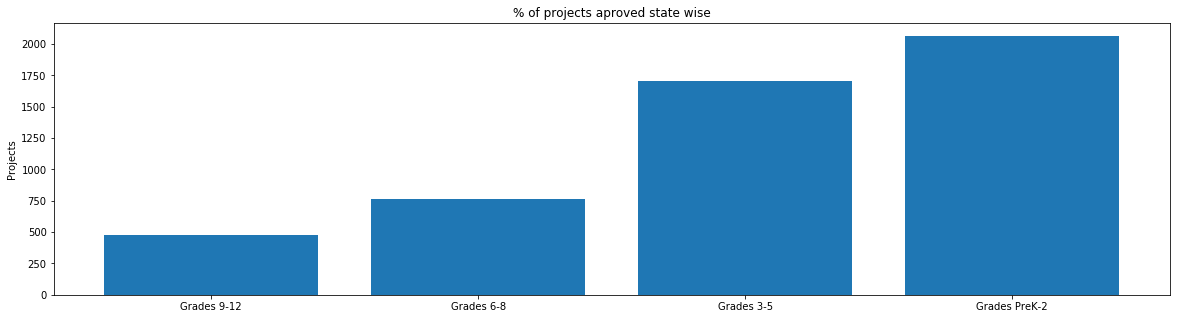

In [253]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
state_dict = dict(my_counter)
sorted_state_dict = dict(sorted(state_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_state_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_state_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved state wise')
plt.xticks(ind, list(sorted_state_dict.keys()))
plt.show()

In [254]:
for i, j in sorted_state_dict.items():
    print("{:20} :{:10}".format(i,j))

Grades 9-12          :       475
Grades 6-8           :       760
Grades 3-5           :      1701
Grades PreK-2        :      2064


In [175]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_state_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['school_state'].values)
print(vectorizer.get_feature_names())


school_state_one_hot = vectorizer.transform(project_data['school_state'].values)
print("Shape of matrix after one hot encodig ",school_state_one_hot.shape)

['VT', 'WY', 'ND', 'AK', 'NE', 'SD', 'DE', 'NH', 'MT', 'DC', 'ME', 'ID', 'NM', 'HI', 'RI', 'WV', 'KS', 'IA', 'AR', 'OR', 'KY', 'MS', 'NV', 'CO', 'AL', 'MN', 'MD', 'CT', 'UT', 'OK', 'WI', 'TN', 'LA', 'VA', 'NJ', 'AZ', 'MA', 'WA', 'MO', 'OH', 'IN', 'PA', 'MI', 'SC', 'GA', 'IL', 'NC', 'FL', 'TX', 'NY', 'CA']
Shape of matrix after one hot encodig  (5000, 51)


#### Summary
- 51 features with 5000 data points

### Categorical data with teacher_prefix


In [176]:
project_data.head(2)


,Unnamed: 0,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price,quantity
66607,132247,p036816,a2ec77419c3b905cb0b993a863e260e3,Mrs.,NC,2016-09-02 14:32:52,Grades 6-8,A zone of self-directed learning: Help us crea...,My middle school students walk into our classr...,Makerspaces are zones of self-directed learnin...,NaN,NaN,My students need bean bag chairs to create a m...,0,0,Literacy_Language Math_Science,Literature_Writing Mathematics,My middle school students walk into our classr...,207.77,12
78558,58194,p005625,1d93830d48afc261e3a41e00c30c9324,Mrs.,MS,2017-03-24 15:08:58,Grades 3-5,Knowledge is Power,I have a group of 27 energetic students. They...,My students live in a small town that does not...,NaN,NaN,My students need more books and technology to ...,0,1,Literacy_Language Math_Science,Literacy Mathematics,I have a group of 27 energetic students. They...,313.60,19


In [258]:
from sklearn.impute import SimpleImputer
my_counter = Counter()
#imp = SimpleImputer(missing_values=np.nan, strategy="most_frequent")
#imp = Imputer(strategy='most_frequent', axis=1)
#imp.fit_transform(project_data['teacher_prefix'].values.reshape(1,-1))
#imp.fit_transform(project_data['teacher_prefix'].values.reshape(1,-1))
#print((project_data['teacher_prefix'].values[57655]))
#project_data['teacher_prefix'].str(x).split()
project_data = project_data.fillna(project_data['teacher_prefix'].value_counts().index[0])
for word in project_data['teacher_prefix'].values:
    my_counter.update(str(word).split())
#project_data = project_data.apply(lambda x: x.str.strip()).replace('', np.nan)
#project_data['teacher_prefix'].replace(r'', np.NaN)

#project_data['teacher_prefix'] = project_data['teacher_prefix'].replace('', np.nan)
#project_data['teacher_prefix'] = project_data['teacher_prefix'].astype(NaN).astype(str)
#for word in project_data['teacher_prefix'].values:
  #  my_counter.update(word.split())
#for word in project_data['school_state'].values:
# my_counter.update(word.split('.'))



In [259]:
my_counter

Counter({'Mrs.': 2630, 'Ms.': 1796, 'Teacher': 97, 'Mr.': 477})

#### Summary
- No of Projects submitted based on Teacher_prefix
- Mrs. approved projects are more and Mr. projects are less

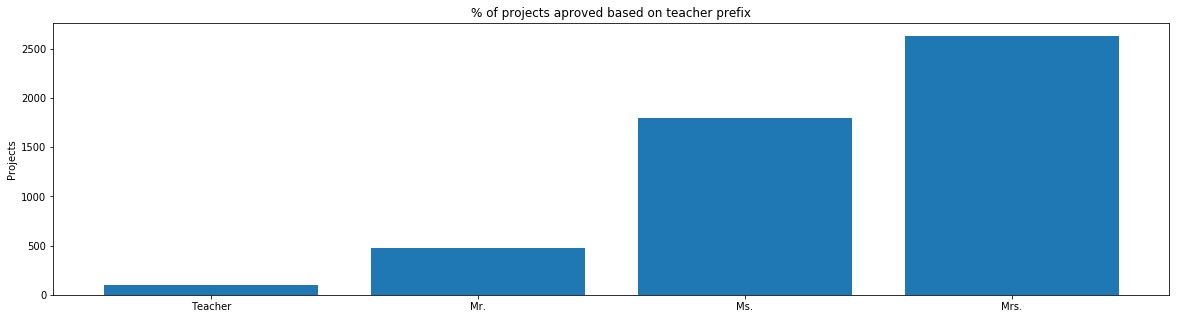

In [260]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
teacher_dict = dict(my_counter)

sorted_teacher_dict = dict(sorted(teacher_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_teacher_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_teacher_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved based on teacher prefix')
plt.xticks(ind, list(sorted_teacher_dict.keys()))
plt.show()

In [261]:
for i, j in sorted_teacher_dict.items():
    print("{:20} :{:10}".format(i,j))

Teacher              :        97
Mr.                  :       477
Ms.                  :      1796
Mrs.                 :      2630


In [262]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_teacher_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['teacher_prefix'].values)
print(vectorizer.get_feature_names())


teacher_prefix_one_hot = vectorizer.transform(project_data['teacher_prefix'].values)
print("Shape of matrix after one hot encodig ",teacher_prefix_one_hot.shape)

['Teacher', 'Mr.', 'Ms.', 'Mrs.']
Shape of matrix after one hot encodig  (5000, 4)


### Categorical data with project_grade_category

In [263]:
my_counter = Counter()
import pdb
for word in project_data['project_grade_category'].values:
    my_counter.update(word.split('\s'))
    

In [264]:
my_counter

Counter({'Grades 6-8': 760,
         'Grades 3-5': 1701,
         'Grades PreK-2': 2064,
         'Grades 9-12': 475})

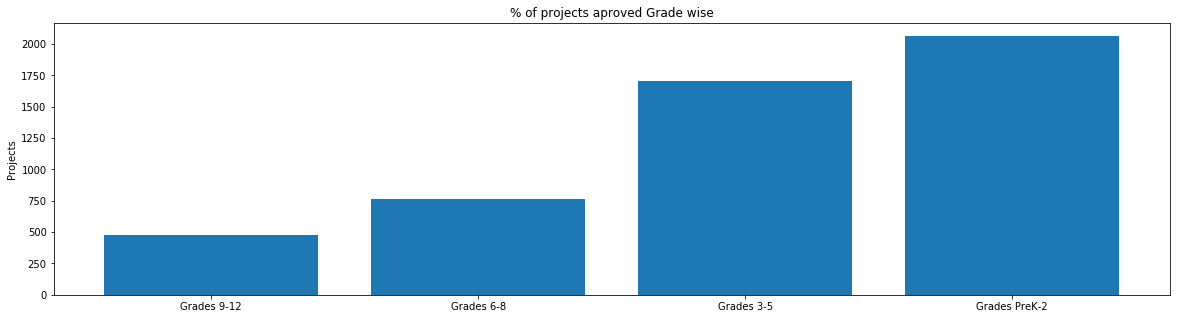

In [265]:
# dict sort by value python: https://stackoverflow.com/a/613218/4084039
project_grade_dict = dict(my_counter)

sorted_project_grade_dict = dict(sorted(project_grade_dict.items(), key=lambda kv: kv[1]))


ind = np.arange(len(sorted_project_grade_dict))
plt.figure(figsize=(20,5))
p1 = plt.bar(ind, list(sorted_project_grade_dict.values()))

plt.ylabel('Projects')
plt.title('% of projects aproved Grade wise')
plt.xticks(ind, list(sorted_project_grade_dict.keys()))
plt.show()

#### Summary
- No of projects apporoved based on Grade wise
- No of projects approved with Grades 9-12 is less
- No of projects approved with Grades PreK-2 is more

In [266]:
for i, j in sorted_project_grade_dict.items():
    print("{:20} :{:10}".format(i,j))

Grades 9-12          :       475
Grades 6-8           :       760
Grades 3-5           :      1701
Grades PreK-2        :      2064


In [267]:
# we use count vectorizer to convert the values into one hot encoded features
vectorizer = CountVectorizer(vocabulary=list(sorted_project_grade_dict.keys()), lowercase=False, binary=True)
vectorizer.fit(project_data['project_grade_category'].values)
print(vectorizer.get_feature_names())


sorted_project_grade_dict_one_hot = vectorizer.transform(project_data['project_grade_category'].values)
print("Shape of matrix after one hot encodig ",sorted_project_grade_dict_one_hot.shape)

['Grades 9-12', 'Grades 6-8', 'Grades 3-5', 'Grades PreK-2']
Shape of matrix after one hot encodig  (5000, 4)


### 1.4.2 Vectorizing Text data

#### 1.4.2.1 BOW for Essays

In [268]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_bow.shape)

Shape of matrix after one hot encodig  (5000, 4358)


#### 1.4.2.2 Bow for Project Title

In [269]:
# We are considering only the words which appeared in at least 10 documents(rows or projects).
vectorizer = CountVectorizer(min_df=10)
text_bow_p = vectorizer.fit_transform(preprocessed_title)
print("Shape of matrix after one hot encodig ",text_bow_p.shape)

Shape of matrix after one hot encodig  (5000, 379)


#### 1.4.2.3 TFIDF vectorizer for Essays

In [270]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf = vectorizer.fit_transform(preprocessed_essays)
print("Shape of matrix after one hot encodig ",text_tfidf.shape)

Shape of matrix after one hot encodig  (5000, 4358)


#### 1.4.2.4 TFIDF vectorizer for Project Title

In [271]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(min_df=10)
text_tfidf_p = vectorizer.fit_transform(preprocessed_title)
print("Shape of matrix after one hot encodig ",text_tfidf_p.shape)

Shape of matrix after one hot encodig  (5000, 379)


#### 1.4.2.5 Avg W2V for Essays

In [272]:
# stronging variables into pickle files python: http://www.jessicayung.com/how-to-use-pickle-to-save-and-load-variables-in-python/
# make sure you have the glove_vectors file
import pickle
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [192]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors.append(vector)

print(len(avg_w2v_vectors))
print(len(avg_w2v_vectors[0]))

100%|██████████| 5000/5000 [00:01<00:00, 2668.47it/s]

5000
300


#### 1.4.2.6 Avg W2V for Project Title

In [193]:
with open('glove_vectors', 'rb') as f:
    model = pickle.load(f)
    glove_words =  set(model.keys())

In [194]:
# average Word2Vec
# compute average word2vec for each review.
avg_w2v_vectors_p = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if word in glove_words:
            vector += model[word]
            cnt_words += 1
    if cnt_words != 0:
        vector /= cnt_words
    avg_w2v_vectors_p.append(vector)

print(len(avg_w2v_vectors_p))
print(len(avg_w2v_vectors_p[0]))

100%|██████████| 5000/5000 [00:00<00:00, 50691.35it/s]

5000
300


#### 1.4.2.7 Using Pretrained Models: TFIDF weighted W2V for Essays

In [195]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_essays)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [196]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_essays): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|██████████| 5000/5000 [00:11<00:00, 384.15it/s]

5000
300


#### 1.4.2.8 Using Pretrained Models: TFIDF weighted W2V for Project Title

In [197]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(preprocessed_title)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [198]:
# average Word2Vec
# compute average word2vec for each review.
tfidf_w2v_vectors_p = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(preprocessed_title): # for each review/sentence
    vector = np.zeros(300) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = model[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors_p.append(vector)

print(len(tfidf_w2v_vectors_p))
print(len(tfidf_w2v_vectors_p[0]))

100%|██████████| 5000/5000 [00:00<00:00, 23613.49it/s]

5000
300


### 1.4.3 Vectorizing Numerical features

#### 1.4.3.1 Vectorizing Numerical features for Price

In [199]:
# check this one: https://www.youtube.com/watch?v=0HOqOcln3Z4&t=530s
# standardization sklearn: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
from sklearn.preprocessing import StandardScaler

# price_standardized = standardScalar.fit(project_data['price'].values)
# this will rise the error
# ValueError: Expected 2D array, got 1D array instead: array=[725.05 213.03 329.   ... 399.   287.73   5.5 ].
# Reshape your data either using array.reshape(-1, 1)

price_scalar = StandardScaler()
price_scalar.fit(project_data['price'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {price_scalar.mean_[0]}, Standard deviation : {np.sqrt(price_scalar.var_[0])}")

# Now standardize the data with above maen and variance.
price_standardized = price_scalar.transform(project_data['price'].values.reshape(-1, 1))

Mean : 293.765026, Standard deviation : 345.8945796369745


In [200]:
price_standardized

array([[-0.24861629],
       [ 0.05734399],
       [-0.50242194],
       ...,
       [ 3.68515452],
       [ 0.42259978],
       [-0.70476683]])

#### 1.4.3.2 Vectorizing Numerical features for the number of previously posted projects

In [201]:
teacher_number_of_previously_posted_projects = StandardScaler()
teacher_number_of_previously_posted_projects.fit(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1,1)) # finding the mean and standard deviation of this data
print(f"Mean : {teacher_number_of_previously_posted_projects.mean_[0]}, Standard deviation : {np.sqrt(teacher_number_of_previously_posted_projects.var_[0])}")

# Now standardize the data with above maen and variance.
Teacher_standardized = teacher_number_of_previously_posted_projects.transform(project_data['teacher_number_of_previously_posted_projects'].values.reshape(-1, 1))

Mean : 11.181, Standard deviation : 28.595500327848786


/home/harikumar415/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/harikumar415/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [202]:
Teacher_standardized

array([[-0.39100557],
       [-0.39100557],
       [-0.25112343],
       ...,
       [ 1.0078159 ],
       [-0.39100557],
       [-0.39100557]])

### 1.4.4 Merging all the above features

- we need to merge all the numerical vectors i.e catogorical, text, numerical vectors

print(categories_one_hot.shape)
print(sub_categories_one_hot.shape)
print(text_bow.shape)
print(price_standardized.shape)
print(price_standardized)

In [273]:
# merge two sparse matrices: https://stackoverflow.com/a/19710648/4084039
from scipy.sparse import hstack
# with the same hstack function we are concatinating a sparse matrix and a dense matirx :)
X = hstack((categories_one_hot, sub_categories_one_hot, text_bow, price_standardized))


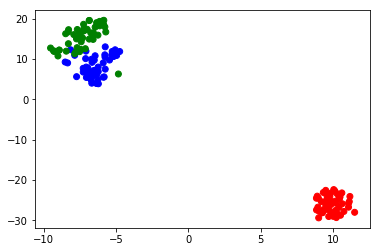

In [274]:
# this is the example code for TSNE
import numpy as np
from sklearn.manifold import TSNE
from sklearn import datasets
import pandas as pd
import matplotlib.pyplot as plt

iris = datasets.load_iris()
x = iris['data']
y = iris['target']

project_data.head(2)
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)

X_embedding = tsne.fit_transform(x)
# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(x.toarray()) , .toarray() will convert the sparse matrix into dense matrix

for_tsne = np.hstack((X_embedding, y.reshape(-1,1)))
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','Score'])
colors = {0:'red', 1:'blue', 2:'green'}
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['Score'].apply(lambda x: colors[x]))
plt.show()

<h2> 2.1 TSNE with `BOW` encoding of `project_title` feature </h2>

[[-19.454144  -34.402065 ]
 [-44.41861   -12.132465 ]
 [-27.971935   22.84225  ]
 ...
 [ -2.1103992 -24.269096 ]
 [-21.251514  -25.444153 ]
 [-16.39421   -43.119663 ]]
      Dimension_x  Dimension_y  project_is_approved
0      -19.454144   -34.402065                  0.0
1      -44.418610   -12.132465                  1.0
2      -27.971935    22.842251                  1.0
3       44.779945    16.174177                  0.0
4      -12.779477    -1.599623                  1.0
5       -7.510756    37.578999                  1.0
6        6.676916   -46.446491                  1.0
7      -42.221619   -21.542315                  1.0
8       25.987753   -22.667973                  1.0
9       -3.632811    -3.934979                  1.0
10      43.628014   -10.691186                  1.0
11       8.144356    18.730650                  1.0
12      39.256622   -10.588590                  1.0
13     -28.406784     4.622075                  1.0
14     -20.966511   -37.360622                  1.0


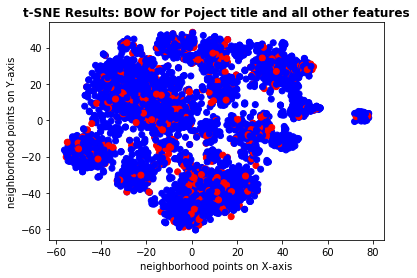

In [275]:
from random import sample 

#merging all features with Bag of words of project title(text_bow_p)
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_one_hot, teacher_prefix_one_hot,sorted_project_grade_dict_one_hot, text_bow_p,price_standardized, Teacher_standardized))
X_Sample = X.tocsr()
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_embedding = tsne.fit_transform(X_Sample.toarray())
print(X_embedding.reshape(-1,2))
y = project_data['project_is_approved']

# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(X_Sample.toarray()) , .toarray() will convert the sparse matrix into dense matrix
for_tsne_BOW = np.hstack((X_embedding,y.values.reshape(-1,1)))
#print(for_tsne)
colors = {0:'red', 1:'blue'}
for_tsne_df = pd.DataFrame(data=for_tsne_BOW, columns=['Dimension_x','Dimension_y','project_is_approved'])
print(for_tsne_df)
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['project_is_approved'].apply(lambda x: colors[x]))
plt.title('t-SNE Results: BOW for Poject title and all other features', weight = 'bold').set_fontsize('12')
plt.xlabel('neighborhood points on X-axis')
plt.ylabel('neighborhood points on Y-axis')
plt.show()


## 2.2 TSNE with `TFIDF` encoding of `project_title` feature

[[  1.419128 -65.50329 ]
 [-18.065416 -56.842636]
 [-44.65749   11.625515]
 ...
 [ 17.213926 -23.900406]
 [ 13.027183 -49.772106]
 [ 27.17064  -51.87227 ]]


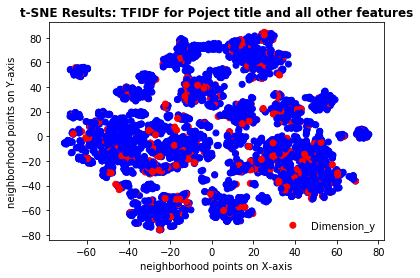

In [229]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_one_hot, teacher_prefix_one_hot,sorted_project_grade_dict_one_hot, text_tfidf_p,price_standardized, Teacher_standardized))
X_Sample = X.tocsr()
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_embedding = tsne.fit_transform(X_Sample.toarray())
X_embedding.reshape(-1,2)
y = project_data['project_is_approved']

# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(X_Sample.toarray()) , .toarray() will convert the sparse matrix into dense matrix
for_tsne_TFIDF = np.hstack((X_embedding,y.values.reshape(-1,1)))
#print(for_tsne)
colors = {0:'red', 1:'blue'}
for_tsne_df = pd.DataFrame(data=for_tsne_TFIDF, columns=['Dimension_x','Dimension_y','project_is_approved'])
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['project_is_approved'].apply(lambda x: colors[x]))
plt.title('t-SNE Results: TFIDF for Poject title and all other features', weight = 'bold').set_fontsize('12')
plt.xlabel('neighborhood points on X-axis')
plt.ylabel('neighborhood points on Y-axis')
plt.legend(frameon=False, loc='lower right', ncol=2)
plt.show()

## 2.3 TSNE with `AVG W2V` encoding of `project_title` feature 


[[ 16.577425  15.31526 ]
 [  9.962667  24.211262]
 [ 21.76384   -6.388685]
 ...
 [-19.913488  16.713463]
 [ 12.053553  47.49383 ]
 [ 43.50648   22.92935 ]]


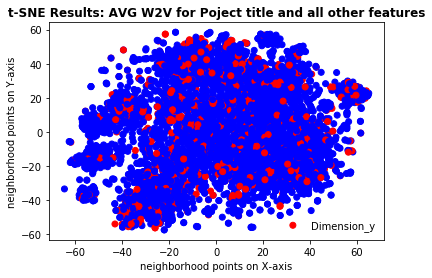

In [230]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_one_hot, teacher_prefix_one_hot,sorted_project_grade_dict_one_hot, avg_w2v_vectors_p,price_standardized, Teacher_standardized))
X_Sample = X.tocsr()
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_embedding = tsne.fit_transform(X_Sample.toarray())
X_embedding.reshape(-1,2)
y = project_data['project_is_approved']

# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(X_Sample.toarray()) , .toarray() will convert the sparse matrix into dense matrix
for_tsne_AVGW2V = np.hstack((X_embedding,y.values.reshape(-1,1)))
#print(for_tsne)
colors = {0:'red', 1:'blue'}
for_tsne_df = pd.DataFrame(data=for_tsne_AVGW2V, columns=['Dimension_x','Dimension_y','project_is_approved'])
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['project_is_approved'].apply(lambda x: colors[x]))
plt.title('t-SNE Results: AVG W2V for Poject title and all other features', weight = 'bold').set_fontsize('12')
plt.xlabel('neighborhood points on X-axis')
plt.ylabel('neighborhood points on Y-axis')
plt.legend(frameon=False, loc='lower right', ncol=2)
plt.show()

## 2.4 TSNE with `TFIDF Weighted W2V` encoding of `project_title` feature 

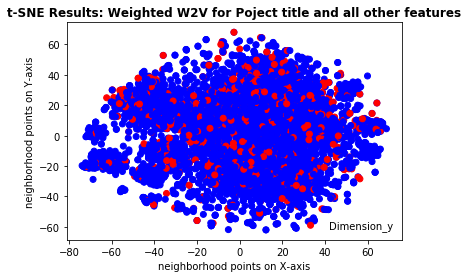

In [231]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_one_hot, teacher_prefix_one_hot,sorted_project_grade_dict_one_hot, tfidf_w2v_vectors_p,price_standardized, Teacher_standardized))
X_Sample = X.tocsr()
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_embedding = tsne.fit_transform(X_Sample.toarray())
X_embedding.reshape(-1,2)
y = project_data['project_is_approved']

# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(X_Sample.toarray()) , .toarray() will convert the sparse matrix into dense matrix
for_tsne_Weighted_W2V  = np.hstack((X_embedding,y.values.reshape(-1,1)))
#print(for_tsne)
colors = {0:'red', 1:'blue'}
for_tsne_df = pd.DataFrame(data=for_tsne_Weighted_W2V, columns=['Dimension_x','Dimension_y','project_is_approved'])
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['project_is_approved'].apply(lambda x: colors[x]))
plt.title('t-SNE Results: Weighted W2V for Poject title and all other features', weight = 'bold').set_fontsize('12')
plt.xlabel('neighborhood points on X-axis')
plt.ylabel('neighborhood points on Y-axis')
plt.legend(frameon=False, loc='lower right', ncol=2)
plt.show()

## 2.6 Concatenate all the features and Apply TNSE on the final data matrix

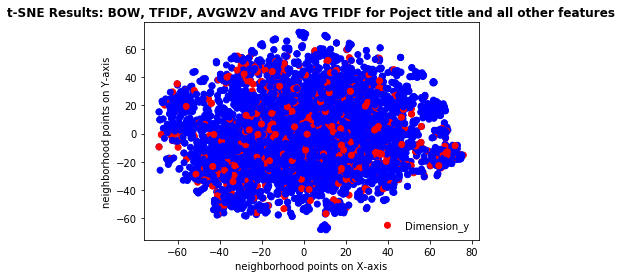

In [232]:
X = hstack((categories_one_hot, sub_categories_one_hot, school_state_one_hot, teacher_prefix_one_hot,sorted_project_grade_dict_one_hot,text_bow_p,text_tfidf_p,avg_w2v_vectors_p,tfidf_w2v_vectors_p,price_standardized, Teacher_standardized))
X_Sample = X.tocsr()
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200)
X_embedding = tsne.fit_transform(X_Sample.toarray())
X_embedding.reshape(-1,2)
y = project_data['project_is_approved']

# if x is a sparse matrix you need to pass it as X_embedding = tsne.fit_transform(X_Sample.toarray()) , .toarray() will convert the sparse matrix into dense matrix
for_tsne  = np.hstack((X_embedding,y.values.reshape(-1,1)))
#print(for_tsne)
colors = {0:'red', 1:'blue'}
for_tsne_df = pd.DataFrame(data=for_tsne, columns=['Dimension_x','Dimension_y','project_is_approved'])
plt.scatter(for_tsne_df['Dimension_x'], for_tsne_df['Dimension_y'], c=for_tsne_df['project_is_approved'].apply(lambda x: colors[x]))
plt.title('t-SNE Results: BOW, TFIDF, AVGW2V and AVG TFIDF for Poject title and all other features', weight = 'bold').set_fontsize('12')
plt.xlabel('neighborhood points on X-axis')
plt.ylabel('neighborhood points on Y-axis')
plt.legend(frameon=False, loc='lower right', ncol=2)
plt.show()

## Summary

- Couldn't able to differentiate projects approved vs projects rejected based on individual features (like 2.1, 2.2, 2.3, 2.4) or by combinig all features(Categorical, numerical and Text data(BOW, TFIDF, AVGW2V and AVGTFIDF))